Data Preparation Complete. Rows: 357
[Notebook] Drawing Heatmap Top View for 71 stacks.


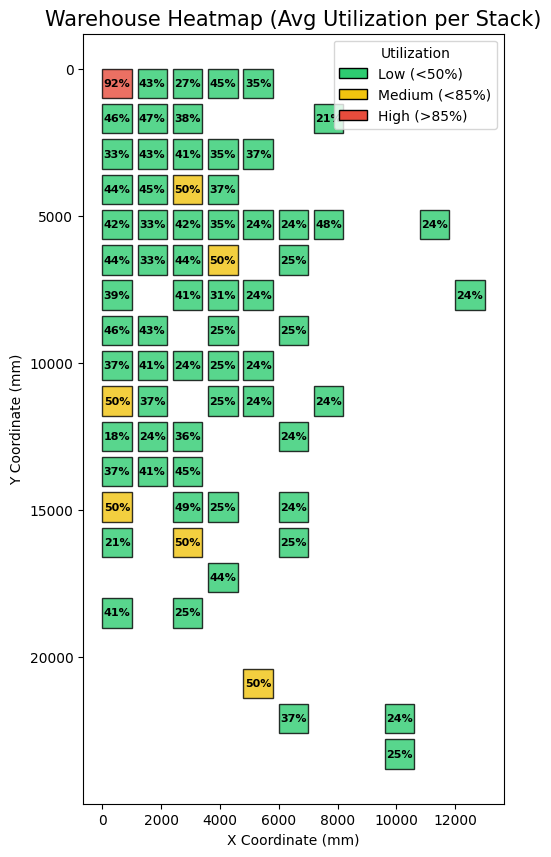

Plotting Front View from 001-001 to 357-001
[Visualizer] Drawing Front View for 71 rack columns.


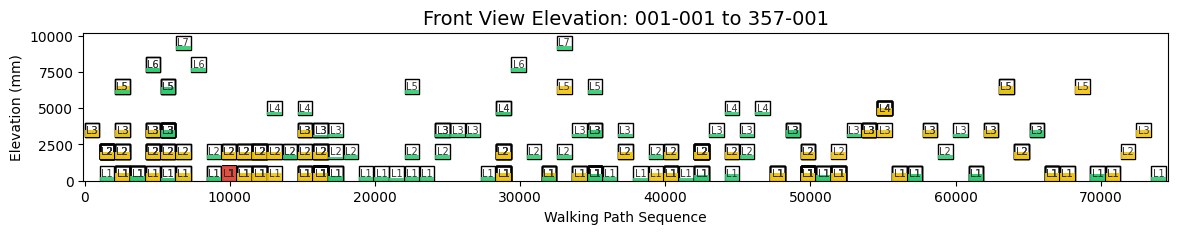

In [3]:
# %% [markdown]
# # Warehouse Inventory Visualization
# This notebook visualizes inventory allocations based on Grid coordinates and Utilization %.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import io

# Import the provided visualizer module
# NOTE: Ensure 'warehouse_visualizer.py' is in the same folder as this notebook.
try:
    import warehouse_visualizer as vis
except ImportError:
    print("Error: 'warehouse_visualizer.py' not found. Please ensure the file is in the directory.")

# %% [markdown]
# ### 2. Data Loading & Transformation
# Since the CSV only provides `GRID` integers (1, 2, 3...) and not Physical Millimeters, we will map them using a standard rack size assumption.
# 
# **Logic:**
# 1. Calculate `utilization` = `CURRENT_STOCK` / `MAX_UNITS`.
# 2. Map `GRID_X` -> Physical `x` (mm).
# 3. Map `GRID_Y` -> Physical `y` (mm).
# 4. Map `GRID_Z` -> Physical `z` (mm).

# %%
# CONFIGURATION FOR SCALING
GRID_PITCH_X = 1200  # mm (Width of aisle + rack)
GRID_PITCH_Y = 1200  # mm (Depth of rack location)
LEVEL_HEIGHT = 1500  # mm (Height of one level)
BIN_WIDTH    = 1000  # mm
BIN_DEPTH    = 1000  # mm
BIN_HEIGHT   = 1000  # mm

# Load Data
df = pd.read_csv('initial_allocations.csv')

# 1. Calculate Utilization %
df['utilization'] = df.apply(
    lambda row: row['CURRENT_STOCK'] / row['MAX_UNITS'] if row['MAX_UNITS'] > 0 else 0, 
    axis=1
)

# 2. Map Grid to Physical Coordinates (Synthesizing the Layout)
# We subtract 1 so Grid 1 starts at 0mm
df['x'] = (df['GRID_X'] - 1) * GRID_PITCH_X
df['y'] = (df['GRID_Y'] - 1) * GRID_PITCH_Y
df['z'] = (df['GRID_Z'] - 1) * LEVEL_HEIGHT

# 3. Assign Dimensions (Assumed standard if not in CSV)
df['width'] = BIN_WIDTH
df['depth'] = BIN_DEPTH
df['height'] = BIN_HEIGHT

# 4. Map columns required by visualizer
df['loc_inst_code'] = df['LOCATION_ID']
df['level_num'] = df['GRID_Z']
df['loc_type'] = df['LOCATION_TYPE']

# Display sanity check
print("Data Preparation Complete. Rows:", len(df))
df[['LOCATION_ID', 'GRID_X', 'x', 'GRID_Y', 'y', 'utilization']].head()

# %% [markdown]
# ### 3. Plot Top View (Heatmap Style)
# The standard visualizer colors by 'Type'. Since you requested the **Front View Color Scheme (Green/Orange/Red based on utilization)** for the Top View, we will define a custom plotting function here that calculates the *Average Utilization* of a stack (Z-axis average) and colors the footprint accordingly.

# %%
def plot_top_view_heatmap(df_locations):
    """
    Plots the Top-Down footprint, colored by Average Stack Utilization
    using the traffic light scheme from the warehouse_visualizer.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_facecolor('white')
    
    # 1. Group by X/Y to get unique stacks and calculate Mean Utilization per stack
    df_footprint = df_locations.groupby(['x', 'y']).agg({
        'width': 'first',
        'depth': 'first',
        'utilization': 'mean' # Key: Average utilization of all levels in this stack
    }).reset_index()

    print(f"[Notebook] Drawing Heatmap Top View for {len(df_footprint)} stacks.")
    
    # 2. Plot
    for _, row in df_footprint.iterrows():
        # Get color based on the AVERAGE utilization of the stack
        color = vis._get_traffic_light_color(row['utilization'])
        
        rect = patches.Rectangle(
            (row['x'], row['y']), 
            row['width'], 
            row['depth'],
            linewidth=1, 
            edgecolor='black', 
            facecolor=color, 
            alpha=0.8
        )
        ax.add_patch(rect)
        
        # Add text for Grid coords (Optional)
        ax.text(row['x'] + row['width']/2, row['y'] + row['depth']/2, 
                f"{int(row['utilization']*100)}%", 
                ha='center', va='center', fontsize=8, color='black', weight='bold')

    # 3. Formatting
    ax.autoscale()
    ax.set_aspect('equal')
    ax.invert_yaxis() 
    ax.set_title("Warehouse Heatmap (Avg Utilization per Stack)", fontsize=15)
    ax.set_xlabel("X Coordinate (mm)")
    ax.set_ylabel("Y Coordinate (mm)")
    
    # Create Custom Legend
    legend_elements = [
        patches.Patch(facecolor=vis.COLORS['low'], edgecolor='black', label='Low (<50%)'),
        patches.Patch(facecolor=vis.COLORS['med'], edgecolor='black', label='Medium (<85%)'),
        patches.Patch(facecolor=vis.COLORS['high'], edgecolor='black', label='High (>85%)')
    ]
    ax.legend(handles=legend_elements, title="Utilization", loc='upper right')
    
    plt.show()

# Execute the Heatmap
plot_top_view_heatmap(df)

# %% [markdown]
# ### 4. Plot Front View (Elevation)
# We use the existing `plot_front_view` from your provided code. 
# We will sort the data to find the First and Last location to define the range.

# %%
# Sort by Location ID to determine a range to plot
sorted_ids = df['LOCATION_ID'].sort_values().tolist()
start_id = sorted_ids[0]  # First ID (e.g. 001-001)
end_id = sorted_ids[-1]   # Last ID (e.g. 093-001)

print(f"Plotting Front View from {start_id} to {end_id}")

# Call the visualizer function
vis.plot_front_view(df, start_id, end_id)

Total Locations: 357
[Notebook] Drawing Top View for 37 stacks.


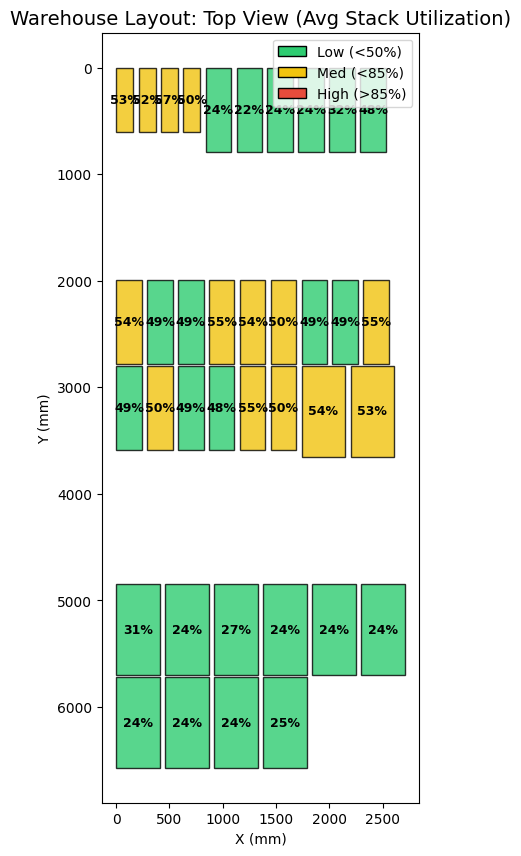

Visualizing Range: A1-00001 to A3-00090
[Visualizer] Drawing Front View for 37 rack columns.


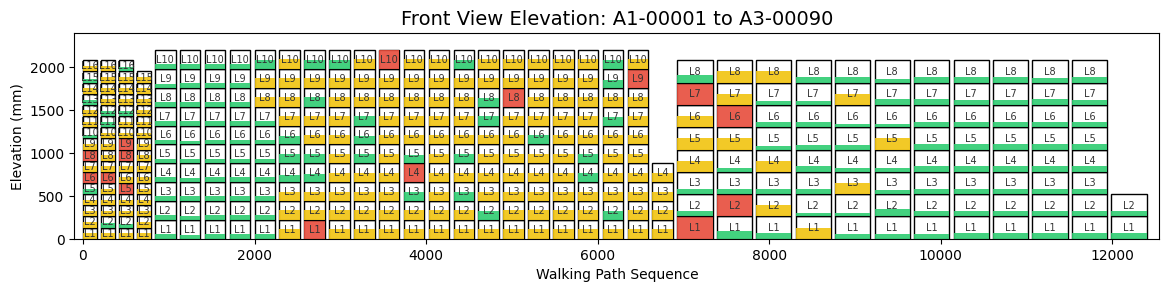

In [1]:
# %% [markdown]
# # Warehouse Visualization: Merging Layout & Allocations
# This notebook reads a rigid physical layout (`locations_dummy.csv`) and merges it with dynamic inventory data (`initial_allocations.csv`) to visualize utilization.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import the provided visualizer module
try:
    import warehouse_visualizer as vis
except ImportError:
    print("Error: 'warehouse_visualizer.py' not found. Please ensure the file is in the directory.")

# %% [markdown]
# ### 1. Generate Sample Files
# We will create the two CSV files locally to ensure the code runs immediately. 
# **Note:** I have aligned the IDs (e.g., `A1-00001`) in both files so the merge works for this demo.

# %%
# Load DataFrames
df_loc = pd.read_csv('locations_dummy.csv')
df_alloc = pd.read_csv('initial_allocations.csv')

# 1. Prepare Allocation Metrics
# Calculate Utilization % in the allocations file first
df_alloc['calculated_utilization'] = df_alloc.apply(
    lambda row: row['CURRENT_STOCK'] / row['MAX_UNITS'] if row['MAX_UNITS'] > 0 else 0, 
    axis=1
)

# 2. Merge (Left Join on Location ID)
# We use Left Join because we want to see ALL locations, even if they have no stock (NaN)
df_merged = pd.merge(
    df_loc, 
    df_alloc[['LOCATION_ID', 'calculated_utilization']], 
    left_on='loc_inst_code', 
    right_on='LOCATION_ID', 
    how='left'
)

# 3. Clean up NaNs (Empty locations = 0% utilization)
df_merged['utilization'] = df_merged['calculated_utilization'].fillna(0.0)

# 4. Final Review
print(f"Total Locations: {len(df_merged)}")
df_merged[['loc_inst_code', 'x', 'y', 'z', 'utilization']].head(10)

# %% [markdown]
# ### 3. Plot Top View (Colored by Average Utilization)
# Since the visualizer's default top view groups by "Type", we define a custom function here to group by "Coordinate Stack" and color by "Average Utilization".

# %%
def plot_layout_top_view(df_data):
    """
    Plots the physical layout footprint. 
    Colors represents the AVERAGE utilization of the stack (Z-axis).
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_facecolor('white')
    
    # Group by X/Y to handle the vertical stack
    # We take the FIRST width/depth (physical dim) and MEAN utilization
    stack_data = df_data.groupby(['x', 'y']).agg({
        'width': 'first',
        'depth': 'first',
        'utilization': 'mean',
        'loc_inst_code': 'count' # just to see how many bins in stack
    }).reset_index()

    print(f"[Notebook] Drawing Top View for {len(stack_data)} stacks.")
    
    for _, row in stack_data.iterrows():
        # Get color based on traffic light logic
        avg_util = row['utilization']
        color = vis._get_traffic_light_color(avg_util)
        
        # Draw footprint
        rect = patches.Rectangle(
            (row['x'], row['y']), 
            row['width'], 
            row['depth'],
            linewidth=1, 
            edgecolor='black', 
            facecolor=color,
            alpha=0.8
        )
        ax.add_patch(rect)
        
        # Annotation: Show Avg %
        ax.text(
            row['x'] + row['width']/2, 
            row['y'] + row['depth']/2, 
            f"{int(avg_util*100)}%", 
            ha='center', va='center', fontsize=9, fontweight='bold', color='black'
        )
        
    # Axis settings
    ax.autoscale()
    ax.set_aspect('equal')
    ax.invert_yaxis() # Warehouse convention
    ax.set_title("Warehouse Layout: Top View (Avg Stack Utilization)", fontsize=14)
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    
    # Legend
    legend_elements = [
        patches.Patch(facecolor=vis.COLORS['low'], edgecolor='black', label='Low (<50%)'),
        patches.Patch(facecolor=vis.COLORS['med'], edgecolor='black', label='Med (<85%)'),
        patches.Patch(facecolor=vis.COLORS['high'], edgecolor='black', label='High (>85%)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.show()

plot_layout_top_view(df_merged)

# %% [markdown]
# ### 4. Plot Front View (Detailed Utilization)
# We use the merged dataframe with the `warehouse_visualizer` to see the exact fill level of every bin.

# %%
# Sort to define range
sorted_locs = df_merged.sort_values('loc_inst_code')['loc_inst_code'].tolist()
start_loc = sorted_locs[0]
end_loc = sorted_locs[-1]

print(f"Visualizing Range: {start_loc} to {end_loc}")

# The merged dataframe already has 'x', 'y', 'z', 'width', 'height', 'utilization'
# which is exactly what the visualizer needs.
vis.plot_front_view(df_merged, start_loc, end_loc)